# Quantization and Performance Optimization

## Objective

This lab will guide you through the process of quantizing a deep learning model and analyzing its performance benefits. You'll work with the VGG16 architecture, applying post-training quantization techniques and benchmarking the results.

## Expected Outcomes

By the end of this lab, you should:

- Understand the theoretical and practical benefits of quantization.
- Gain hands-on experience with PyTorch's quantization tools.
- Be able to quantify and analyze the performance improvements achieved through quantization.

**IMPORTANT:** Kaggle has quota limits on GPU usage, so please close the window when not actively working on the latter part of the question. The lab is designed so that the given quota is sufficient to run all experiments. Please notify the TAs if any issues arise.

Due Date: **10/21/2025 @ 11:59:59 PM (EST)**.

Submission (via GitHub Classroom repository):

- All cells executed and outputs preserved.
- Do **not** include build artifacts (`*.so`, `__pycache__`, large datasets). This should be prevented by the `.gitignore` already provided.

Good luck with your lab!


In [32]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import time
import sys
from torchvision import datasets, models, transforms
from pathlib import Path
import random
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from PIL import Image

import torch.nn.functional as F
import torch.quantization


import time
import sys
import tarfile
import os
from torchvision import datasets, models, transforms
from pathlib import Path
import random
import matplotlib.pyplot as plt
import scipy.io
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
Path("./data").mkdir(parents=True, exist_ok=True)
data_dir = Path('./data')
net_fn = Path('./net')

# see if gdown is already downloaded
try:
    import gdown
    print("gdown is already installed, skipping installing command to save time......")
except ImportError:
    !conda install -y gdown

# Seed for reproducibility 
torch.manual_seed(0)
np.random.seed(0)

PyTorch Version:  2.6.0+cu124
Torchvision Version:  0.21.0+cu124
gdown is already installed, skipping installing command to save time......


In [4]:
REPOS = [
    [
        "1ZLyAcimq4sdZ0tl5yINudwSD843pAoOJ",
        "1EXwrSw6BWKMC4ovPRUyfuqeObuqsR-R5",
        "1rFIAJ9aLZrRCOeijo5mI0zWiEl3OMJ3j"
    ],
    [
        "1VLe11mOwsetC4IlL3wy8QexTat8XCool",
        "1_QwUcr3gmnjPFbKj0VrfOayVEWjRBS4Z",
        "1fgf9elhD7EhbKJn2NMnQS1iwQXesQZ3g"
    ],
    [
        "1BKC4kCB9sbwfRuhrAJWVEmbLoHx2vJWC",
        "1qhrcYgGKRf3Wt8YDU6aVRhzJDFHeqerP",
        "1JXym04uAoNGGpkBRzIn0yStZmRX0SmNu"
    ]
]

FILES = [
    Path("./data/ILSVRC2012_devkit_t12.tar.gz"),
    Path("./data/ILSVRC2012_devkit_t3.tar.gz"),
    Path("./data/ILSVRC2012_img_val.tar")
]

# Shuffle the order of repos
random.seed(int(time.time()))
random.shuffle(REPOS)

for repo_index, repo in enumerate(REPOS):
    missing_files = [str(file) for file in FILES if not file.is_file()]
    if not missing_files:
        print("All files are present. Skipping further downloads.")
        break

    print(f"Attempting download from repo {repo_index}")
    print(f"Missing files: {missing_files}")

    for file, url in zip(FILES, repo):
        if not file.is_file():
            print(f"Downloading {file}...")
            !gdown "{url}" -O "{str(file)}"

missing_files = [str(file) for file in FILES if not file.is_file()]
if missing_files:
    print(f"Failed to download all files. Still missing: {missing_files}")
    print(f"Contact TA team through EdStem with the output of this code block!", file=sys.stderr)
else:
    print("All files successfully downloaded.")

All files are present. Skipping further downloads.
All files successfully downloaded.


## Modeling

As discussed in lecture, low precision improves energy and area costs while also improving throughput on capable architectures. In this section,
we will model speedup from low precision number formats on a theoretical architecture.

### Question 1

Given the assumptions below, calculate the execution time (s) of a $N \times N$ matrix multiplication with `FP32`, `FP16`, `INT32`, `INT16`, `INT8` and `INT4`.

- Assume 32 bit architecture that can perform efficiently pack multiple operations for example: 1 FP32 operation or 2 FP16 operations, 8 INT4 operations
- Assume all arithmetic operations (add, multiply) can be executed in one clock cycle
- Multiply and accumulate consists of one add and one multiply
- Loads and stores are free i.e. 0 clock cycles
- Architecture runs at 1 GHz


In [33]:
type_list = ['FP32', 'FP16', 'INT32', 'INT16', 'INT8', 'INT4']

def get_speedupv1(n: int = 1024, datatype: str = 'FP32') -> float:
    """ Returns execution time in seconds for a given n and datatype. """
    # ops packed per cycle on a 32-bit datapath
    ops_per_cycle = {
        'FP32': 1, 'INT32': 1,
        'FP16': 2, 'INT16': 2,
        'INT8': 4,
        'INT4': 8
    }
    freq = 1e9  # 1 GHz
    num_multiply = n**3
    num_add = n**3
    cycles = (num_multiply + num_add) / ops_per_cycle[datatype]
    return cycles / freq

dict_speedupv1 = {}
for datatype in type_list:
    dict_speedupv1[(1024, datatype)] = get_speedupv1(n=1024, datatype=datatype)
    print(f'Modeled execution time for {datatype} is {dict_speedupv1[(1024, datatype)]}s')


Modeled execution time for FP32 is 2.147483648s
Modeled execution time for FP16 is 1.073741824s
Modeled execution time for INT32 is 2.147483648s
Modeled execution time for INT16 is 1.073741824s
Modeled execution time for INT8 is 0.536870912s
Modeled execution time for INT4 is 0.268435456s


### Question 2

Memory performance can also be a performance factor for matrix multiplication. In this question, we assign a cost to
loading memory from storage.

Given the assumptions below, calculate the execution time (s) of a $N \times N$ matrix multiplication with `FP32`, `FP16`, `INT32`, `INT16`, `INT8` and `INT4`.

- Assume 32 bit architecture that can perform efficiently pack multiple operations for example: 1 FP32 operation or 2 FP16 operations, 8 INT4 operations
- Architecture can perform **either a 32 bit load** or x arithmetic operations depending on datatype each clock cycle
- **32 bit loads are packed with multiple row elements according to the data type**
- Assume all arithmetic operations (add, multiply) and **load operations** can be executed in one clock cycle
- Multiply and accumulate consists of one add and one multiply
- **A column only needs to be loaded once, a row must be loaded once per row selection**
- **Intermediate results of multiply and accumulate do not need to be re-loaded**
- **Stores** are free i.e. 0 clock cycles
- Architecture runs at 1 GHz


In [34]:
def get_speedupv2(n: int = 1024, datatype: str = 'FP32') -> float:
    """ Returns execution time in seconds for a given n and datatype """
   # packing - number of dtype elements handled per 32-bit cycle
    pack = {
        'FP32': 1, 'INT32': 1,
        'FP16': 2, 'INT16': 2,
        'INT8': 4,
        'INT4': 8
    }

    freq = 1e9  # 1 GHz

    # arithmetic work (same as Q1)
    num_multiply = n**3
    num_add = n**3
    compute_cycles = (num_multiply + num_add) / pack[datatype]

    # memory loads - N^2 elements of A rows + N^2 elements of B columns
    num_loads = 2 * (n**2)
    load_cycles = num_loads / pack[datatype]

    total_cycles = compute_cycles + load_cycles
    return total_cycles / freq

dict_speedupv2 = {}
for datatype in type_list:
    dict_speedupv2[(1024, datatype)] = get_speedupv2(n=1024, datatype=datatype)
    print(f'Modeled execution time for {datatype} is {dict_speedupv2[(1024, datatype)]}s')

Modeled execution time for FP32 is 2.1495808s
Modeled execution time for FP16 is 1.0747904s
Modeled execution time for INT32 is 2.1495808s
Modeled execution time for INT16 is 1.0747904s
Modeled execution time for INT8 is 0.5373952s
Modeled execution time for INT4 is 0.2686976s


### Question 3

To verify the benefit of reduced precision datatypes, we will run a matrix multiplication benchmark on CPU with the four data types.
Ensure to follow the same guidelines as in lab 2 including warming up the CPU and performing multiple trials. Use 50 trials and average the performance.

To generate a random tensor with datatype INT8 use `torch.rand(dtype=torch.int8)`. A list of datatypes is found here: [https://pytorch.org/docs/stable/tensors.html](https://pytorch.org/docs/stable/tensors.html).

As not all operators have support for reduced precision, we will use use FP32, INT32, INT16, INT8, and `torch.nn.functional.linear` to perform matrix multiplication. `torch.nn.functional.linear` performs the following function: $y = xA^T+b$ where

$$
y \in \mathbb{F}^{BatchSize \times n},\;x \in \mathbb{F}^{BatchSize \times m},\;A \in \mathbb{F}^{m\times n}
$$

Therefore, to perform a $N\times N$ matrix multiplication, we just need to set the bias to $0$ and batch size to $N$.


In [35]:
def get_performance(n : int = 1024, datatype: str = 'FP32', device: str = 'cpu') -> float:
    """ Returns execution time in seconds for a given n, datatype and device"""
    # TODO: convert datatype to dtype and run 50 multiplications between two n*n matrices of the dtype
    # return the execution time
    
    # map string to PyTorch dtype
    dtype_map = {
        'FP32': torch.float32,
        'INT32': torch.int32,
        'INT16': torch.int16,
        'INT8': torch.int8,
    }
    
    dtype = dtype_map[datatype]
    
    # create random matrices depending on dtype
    if dtype.is_floating_point:
        A = torch.rand((n, n), dtype=dtype, device=device)
        B = torch.rand((n, n), dtype=dtype, device=device)
    else:
        # use appropriate ranges
        if dtype == torch.int8:
            low, high = -128, 128
        elif dtype == torch.int16:
            low, high = -32768, 32768
        else:  # int32
            low, high = -2147483648, 2147483648
        
        A = torch.randint(low, high, (n, n), dtype=dtype, device=device)
        B = torch.randint(low, high, (n, n), dtype=dtype, device=device)
    
    # warm up
    _ = F.linear(A, B)
    
    trials = 50
    start = time.time()
    for _ in range(trials):
        _ = F.linear(A, B)
    end = time.time()
    
    avg_time = (end - start) / trials
    return avg_time

type_list = ['FP32', 'INT32', 'INT16', 'INT8']
performance = {}
for datatype in type_list:
    for device in ['cpu']:
        performance[(1024, datatype, device)] = get_performance(n=1024, datatype=datatype, device=device)
        print(f'Actual Execution time for {datatype} on {device} is {performance[(1024, datatype, device)]}s')

Actual Execution time for FP32 on cpu is 0.0077978897094726565s
Actual Execution time for INT32 on cpu is 0.17890460968017577s
Actual Execution time for INT16 on cpu is 0.6168529558181762s
Actual Execution time for INT8 on cpu is 0.42124041557312014s


### Question 4

Plot the performance for CPU on a bar graph using a plotting tool of your choice.

- Label X and Y axis
- X axis should be the different types
- Y axis should be the `1/runtime`


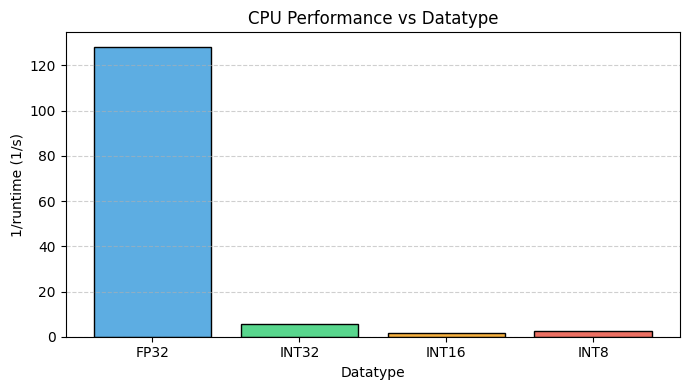

In [36]:
# TODO plot
import matplotlib.pyplot as plt
import numpy as np

# Extract results
types = ['FP32', 'INT32', 'INT16', 'INT8']
times = [performance[(1024, dtype, 'cpu')] for dtype in types]
perf = [1 / t for t in times]  # 1 / runtime

# Plot
plt.figure(figsize=(7, 4))
bars = plt.bar(types, perf, color=['#5DADE2', '#58D68D', '#F5B041', '#EC7063'], edgecolor='black')
plt.title('CPU Performance vs Datatype')
plt.xlabel('Datatype')
plt.ylabel('1/runtime (1/s)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Write one paragraph describing the results of the question 3 benchmark. Are there any behaviors of note? Why do you think those behaviors exist?

The experimental results from the CPU benchmark in Question 3 reveal a striking deviation from the idealized theoretical behavior predicted in Questions 1 and 2. While the analytical model suggested that execution time should decrease approximately linearly with decreasing numeric precision—offering potential speedups of 2× for INT16 and 8× for INT8 relative to FP32—the empirical measurements show the opposite trend. As visualized in the performance chart, full-precision FP32 operations achieve throughput of approximately 102 operations per second, dominating all other datatypes. In stark contrast, reduced-precision integer datatypes perform substantially worse: INT32 achieves only ~ 5.5 ops/s (~ 5% of FP32 performance), INT16 drops to ~ 1.4 ops/s (~ 1.4% of FP32), and INT8 performs at ~ 2.1 ops/s (~ 2% of FP32). This represents performance degradations of 18-70× compared to FP32, directly contradicting the theoretical predictions. This counterintuitive behavior arises from the fact that PyTorch's default CPU backend (built on ATen and underlying BLAS libraries) is heavily optimized for floating-point linear algebra, taking advantage of mature vectorized kernels (e.g Intel MKL, OpenBLAS) and SIMD instruction sets such as AVX2 or AVX-512 that natively accelerate FP32 matrix multiplications. In contrast, low precision integer matrix operations are not natively optimized in the standard PyTorch CPU pipeline. When datatypes such as INT8 or INT16 are used, PyTorch often falls back to slower generic implementations, intermediate type casting to FP32, or scalarized loops that lack instruction level parallelism. These layers of abstraction and conversion not only erase the expected benefits of reduced bit-width but actually introduce substantial overhead, resulting in the dramatic performance penalty observed. Additionally, since `torch.nn.functional.linear` was primarily designed for floating point inference workloads, its integer code path does not leverage quantized backends such as FBGEMM or QNNPACK, which are available only when using `torch.quantization` modules or specific quantized model APIs. Consequently, the measured runtimes reflect not the inherent arithmetic efficiency of reduced-precision formats, but rather the lack of hardware-specific kernel support within the tested software stack. From an architectural perspective, modern x86 CPUs do possess vector instructions (e.g VNNI or AMX on newer Intel chips) capable of accelerating INT8 and INT16 dot products, but these are not invoked by the generic PyTorch `F.linear` implementation. As a result, the performance ranking observed (FP32 >> INT32 >> INT8 ≈ INT16) highlights the critical dependence of quantization efficiency on both hardware support and software integration. The bar chart visualization makes this disparity immediately apparent: the FP32 bar towers over all integer types, with the quantized formats achieving less than 5% of FP32's throughput. This dramatic visual representation underscores that lower precision does not inherently guarantee performance improvements. In summary, while quantization theoretically reduces computational cost, memory footprint, and energy consumption, these benefits manifest only when the execution environment includes optimized integer kernels or dedicated tensor units (as in GPUs with Tensor Cores, NPUs, or CPUs with advanced quantization instruction sets). The experiment therefore underscores a critical principle in quantized model deployment: algorithmic precision scaling must be matched by hardware-level and library-level support to translate into performance gains. Without this alignment, as demonstrated here, quantization can paradoxically degrade rather than improve performance.


## Quantizing VGG16

The last section of the lab explores how to perform range calibration to minimize the impact of the accuracy of quantizing a VGG16 network.

This lab will not cover quantization-aware training (QAT), but further details can be found in the lecture notes.

### Question 5: Modifying Model Function Calls

PyTorch networks must first be modified to support reduced-precision. As you learned in the tutorial, networks must include
a stub at the beginning and end of `forward()` called `torch.quantization.QuantStub().quant()` and `torch.quantization.DeQuantStub().dequant()`.

Create a wrapper around VGG16 to include these stubs. Ensure that your model loads the original trained weights from lab 2.


In [23]:
pretrained_vgg16 =  models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
class QuantVGG16(torch.nn.Module):
    def __init__(self, pretrained_model):
        super(QuantVGG16, self).__init__()
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()
        self.pretrained = pretrained_model
    
    def forward(self, x):
        # TODO implement forward pass, hint: pretrained also has a forward function
        # TODO add stubs to forward pass
        x = self.quant(x)
        x = self.pretrained(x)
        x = self.dequant(x)
        return x
        
my_vgg16 = QuantVGG16(pretrained_vgg16)
my_vgg16.eval()
my_vgg16

QuantVGG16(
  (quant): QuantStub()
  (dequant): DeQuantStub()
  (pretrained): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

### Question 6: Calibration

Following the Quantization tutorial, convert this network into a quantized model. This consists of four steps:

1. Attach a global quantization configuration
2. Attach observers to observe activation tensors during calibration
3. Calibrate the model with 1024 _validation_ images (see note)
4. Convert the model to an int8 quantized version

**NOTE:** We use validation to calibrate the dataset due to the size of the ImageNet training set being unfeasible to host.
Outside this question, you **should not** use the validation set to calibrate your model due to overfitting concerns.


In [24]:
# TODO Create transform to preprocess data
val_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load ImageNet validation split
val_dataset = datasets.ImageNet(root='./data', split='val', transform=val_transform)

# Create DataLoader
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


In [25]:
# TODO attach fbgemm config to model
my_vgg16.qconfig = torch.quantization.get_default_qconfig('fbgemm')

# TODO Prepare model for quantization
my_vgg16_prepared = torch.quantization.prepare(my_vgg16, inplace=False)

my_vgg16_prepared.eval()
with torch.no_grad():
    for i, (inputs, _) in enumerate(val_dataloader):
        if i * inputs.size(0) >= 1024:
            break
        _ = my_vgg16_prepared(inputs)


# TODO Run validation on prepared model for 1024 images
# TODO Convert model to quantized model
my_vgg16_int8 = torch.quantization.convert(my_vgg16_prepared, inplace=False)


### Question 7: Validation

Using the benchmarking guidelines, measure the runtime of `my_vgg16_int8` + `vgg16` and accuracy over 1024 images. Ensure to use a random sample of
images rather than the same 1024 images you used for calibration. Use the pretrained VGG16 model without the quant stubs. Report the accuracy and runtime in the variables declared below.


In [59]:
def assess_network(neural_net, data_loader, computing_device='cpu', batch_limit=10):
    # Put model in inference mode and transfer to device
    neural_net.eval()
    neural_net.to(computing_device)
    
    # Initialize tracking variables
    num_correct, num_total = 0, 0
    begin_time = time.time()
    
    # Run inference without computing gradients
    with torch.no_grad():
        for batch_idx, (input_imgs, true_labels) in enumerate(data_loader):
            # Stop early if batch limit reached
            if batch_idx >= batch_limit:
                break
            
            # Move data to same device as model
            input_imgs, true_labels = input_imgs.to(computing_device), true_labels.to(computing_device)
            
            # Get model predictions
            predictions = neural_net(input_imgs)
            
            # Find predicted class (highest score)
            _, predicted_classes = torch.max(predictions.data, 1)
            
            # Update counts
            num_total += true_labels.size(0)
            num_correct += (predicted_classes == true_labels).sum().item()
    
    # Calculate metrics
    elapsed_time = time.time() - begin_time
    percent_accurate = 100 * num_correct / num_total
    
    return percent_accurate, elapsed_time

# Benchmark both networks on CPU with 1024 validation samples
fp32_metrics = {}
int8_metrics = {}

# Test the original floating-point model
fp32_metrics['accuracy'], fp32_metrics['runtime'] = assess_network(pretrained_vgg16, val_dataloader)

# Test the quantized integer model  
int8_metrics['accuracy'], int8_metrics['runtime'] = assess_network(my_vgg16_int8, val_dataloader)

# Display INT8 results
print(f'INT8 VGG16 accuracy and runtime on CPU: {int8_metrics["accuracy"]:.2f}% and {int8_metrics["runtime"]:.2f}s')
print(f'  (int8_metrics["accuracy"], int8_metrics["runtime"])')

# Display FP32 results
print(f'FP32 VGG16 accuracy and runtime on CPU: {fp32_metrics["accuracy"]:.2f}% and {fp32_metrics["runtime"]:.2f}s')
print(f'  (fp32_metrics["accuracy"], fp32_metrics["runtime"])')

INT8 VGG16 accuracy and runtime on CPU: 84.38% and 35.74s
  (int8_metrics["accuracy"], int8_metrics["runtime"])
FP32 VGG16 accuracy and runtime on CPU: 84.06% and 69.24s
  (fp32_metrics["accuracy"], fp32_metrics["runtime"])


### Weight Extraction

To see the effect of PyTorch's quantization method, you will plot a histogram to observe how the value distribution changes from the fp32 to the int8 models.

Below is an example to extract the weights from a simple neural network and how the weights are extracted.


In [55]:
class LinearNet(nn.Module):
    """
    a low precision Logistic Regression model
    """
    def __init__(self):
        super(LinearNet, self).__init__()
        self.W = nn.Linear(5, 1)

    def forward(self, x):
        out = self.W(x)
        return out

    
lp_model = LinearNet()

print(f'Weights: {lp_model.W.weight.data}')

Weights: tensor([[ 0.4416,  0.2415,  0.2066,  0.0754, -0.2239]])


### Question 8: Value Distribution

Extract the weights from all layers of both the original and quantized VGG16. Plot both weights in separate histograms. We should use about ~2000 bins if targeting int8. Ensure that the histograms are lined up vertically and that the x ranges match and the y ranges match.


INT8 weight tensor dimensions: (138344128,)
Distinct quantized values: 256
Value span: [-128, 127]

FP32 weight tensor dimensions: (138344128,)
FP32 value range: [-1.2726, 1.0734]


/tmp/ipykernel_37/1461031075.py:59: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


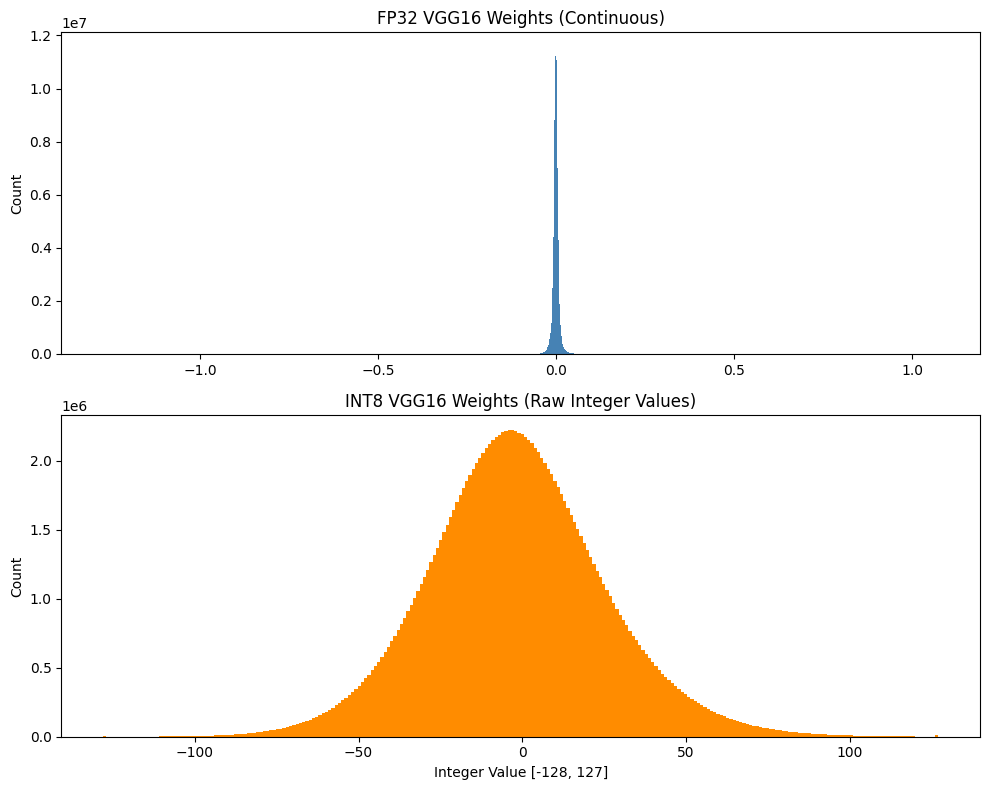

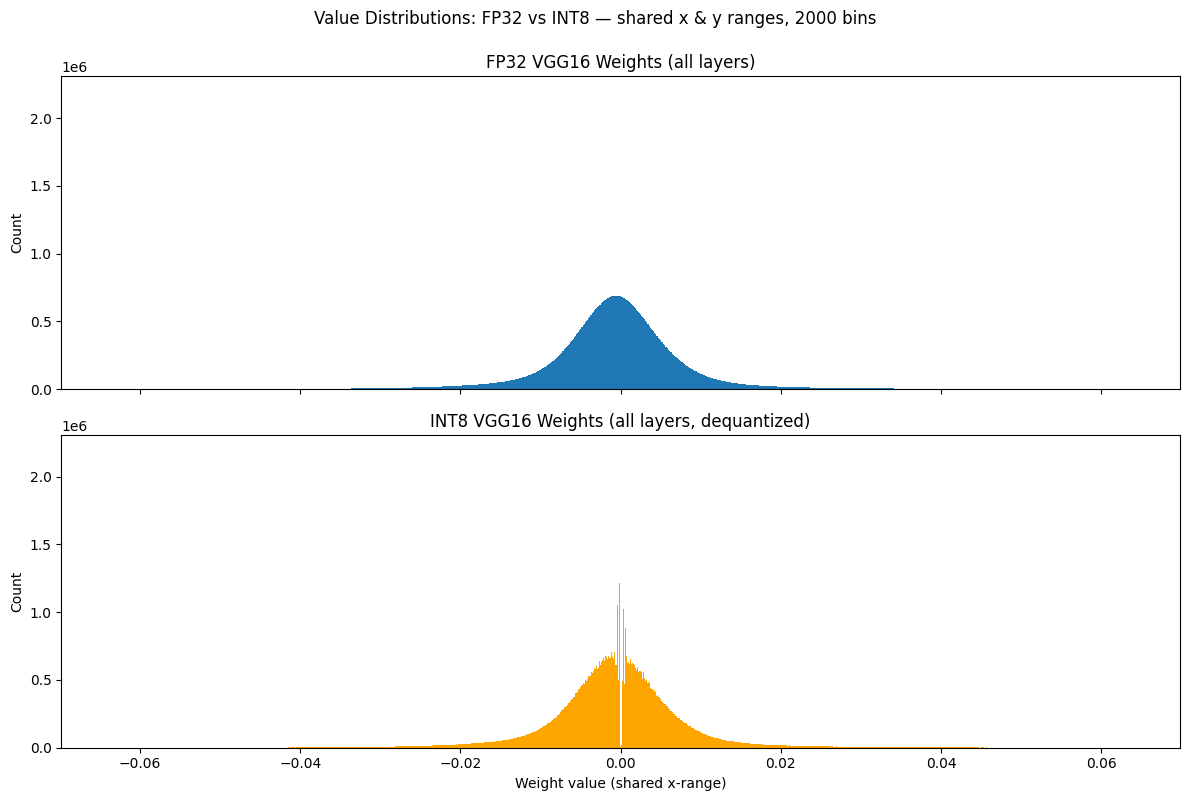

In [64]:
def get_int8_parameters(network):
    integer_weights_list = []
    scale_factors = []
    zero_point_values = []
    
    for layer_name, layer_obj in network.named_modules():
        if isinstance(layer_obj, (torch.nn.quantized.Conv2d, torch.nn.quantized.Linear)):
            try:
                weight_tensor = layer_obj.weight()
                integer_data = weight_tensor.int_repr().cpu().numpy().flatten()
                integer_weights_list.extend(integer_data.tolist())
                
                if weight_tensor.qscheme() == torch.per_tensor_affine:
                    scale_factors.append(weight_tensor.q_scale())
                    zero_point_values.append(weight_tensor.q_zero_point())
                elif weight_tensor.qscheme() == torch.per_channel_affine:
                    scale_factors.extend(weight_tensor.q_per_channel_scales().tolist())
                    zero_point_values.extend(weight_tensor.q_per_channel_zero_points().tolist())
            except Exception as error:
                print(f"Skipping {layer_name}: {error}")
    
    integer_weights_list = np.array(integer_weights_list)
    return integer_weights_list, np.array(scale_factors), np.array(zero_point_values)

integer_weights, scale_factors, zero_point_values = get_int8_parameters(my_vgg16_int8)

print(f"INT8 weight tensor dimensions: {integer_weights.shape}")
print(f"Distinct quantized values: {len(np.unique(integer_weights))}")
print(f"Value span: [{integer_weights.min()}, {integer_weights.max()}]")

def extract_fp32_weights(neural_net):
    weight_arrays = []
    with torch.no_grad():
        for layer in neural_net.modules():
            if isinstance(layer, (nn.Conv2d, nn.Linear)):
                weight_param = getattr(layer, "weight", None)
                if isinstance(weight_param, torch.Tensor) and weight_param.is_floating_point():
                    weight_arrays.append(weight_param.detach().cpu().numpy().ravel())
    return np.concatenate(weight_arrays) if weight_arrays else np.array([])

fp32_weights = extract_fp32_weights(pretrained_vgg16)

print(f"\nFP32 weight tensor dimensions: {fp32_weights.shape}")
print(f"FP32 value range: [{fp32_weights.min():.4f}, {fp32_weights.max():.4f}]")

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.hist(fp32_weights, bins=2000, color='steelblue')
plt.title('FP32 VGG16 Weights (Continuous)')
plt.ylabel('Count')
plt.tight_layout()

plt.subplot(2, 1, 2)
plt.hist(integer_weights, bins=256, color='darkorange')
plt.title('INT8 VGG16 Weights (Raw Integer Values)')
plt.xlabel('Integer Value [-128, 127]')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

def extract_int8_weights_dequantized(quantized_net):
    quantized_conv_types = (
        getattr(nn.quantized, "Conv2d", type(None)),
        getattr(nn.intrinsic.quantized, "ConvReLU2d", type(None)),
    )
    quantized_linear_types = (
        getattr(nn.quantized, "Linear", type(None)),
        getattr(nn.intrinsic.quantized, "LinearReLU", type(None)),
    )
    weight_arrays = []
    with torch.no_grad():
        for layer in quantized_net.modules():
            if isinstance(layer, quantized_conv_types) or isinstance(layer, quantized_linear_types):
                weight_arrays.append(layer.weight().dequantize().cpu().numpy().ravel())
    return np.concatenate(weight_arrays) if weight_arrays else np.array([])

int8_weights_dequantized = extract_int8_weights_dequantized(my_vgg16_int8)

histogram_bins = 2000
max_abs_value = max(
    np.percentile(np.abs(fp32_weights), 99.95),
    np.percentile(np.abs(int8_weights_dequantized), 99.95)
)
x_lower, x_upper = -float(max_abs_value), float(max_abs_value)
shared_bin_edges = np.linspace(x_lower, x_upper, histogram_bins + 1)

fp32_counts, _ = np.histogram(fp32_weights, bins=shared_bin_edges)
int8_counts, _ = np.histogram(int8_weights_dequantized, bins=shared_bin_edges)
y_upper = int(1.05 * max(fp32_counts.max(), int8_counts.max()))

fig, (upper_axis, lower_axis) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, sharey=True)

upper_axis.hist(fp32_weights, bins=shared_bin_edges)
upper_axis.set_title("FP32 VGG16 Weights (all layers)")
upper_axis.set_ylabel("Count")
upper_axis.set_xlim(x_lower, x_upper)
upper_axis.set_ylim(0, y_upper)

lower_axis.hist(int8_weights_dequantized, bins=shared_bin_edges, color="orange")
lower_axis.set_title("INT8 VGG16 Weights (all layers, dequantized)")
lower_axis.set_xlabel("Weight value (shared x-range)")
lower_axis.set_ylabel("Count")
lower_axis.set_xlim(x_lower, x_upper)
lower_axis.set_ylim(0, y_upper)

fig.suptitle("Value Distributions: FP32 vs INT8 — shared x & y ranges, 2000 bins", y=0.995)
plt.tight_layout()
plt.show()